In [ ]:
import keras
import keras.backend as K
from keras import initializers, activations
from keras.models import load_model
from keras.utils import plot_model
from keras import models
import tensorflow as tf
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
from random import seed, choice, randint
import cv2
import datetime
from shutil import copyfile, move
from scipy.stats import rankdata
import math
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
!conda install -y gdown


Retrieving notices: ...working... done
Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - 

In [ ]:
from tensorflow.keras import backend as K

import gc



In [ ]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x = np.array(data['data'])
    y = np.array(data['label'])
    x = x.transpose((0,2,3,1))
    return x, y

In [ ]:
def normalize(x):
    return x/255

In [ ]:
def evalcustommodel(clean_data_filename, bd_model):
    clean_data_filename = str(clean_data_filename)
    x_test, y_test = data_loader(clean_data_filename)
    x_test = normalize(x_test)
    clean_label_p = np.argmax(bd_model.predict(x_test), axis=1)
    class_accu = np.mean(np.equal(clean_label_p, y_test))*100
    return class_accu

In [ ]:
def calc_bottom_X_percent_weight(weights, fraction):
  max = weights[0][0][0][0]
  min = weights[0][0][0][0]
  for i in range(len(weights)):
    for j in range(len(weights[i])):
      for k in range(len(weights[i][j])):
        for m in range(len(weights[i][j][k])):
          if weights[i][j][k][m] < min:
            min = weights[i][j][k][m]
          if weights[i][j][k][m] > max:
            max = weights[i][j][k][m]
  truemin = min+(fraction*(max-min))
  return truemin

In [ ]:
def clear_min_weights(weights, thresh):
  for i in range(len(weights)):
    for j in range(len(weights[i])):
      for k in range(len(weights[i][j])):
        for m in range(len(weights[i][j][k])):
          if weights[i][j][k][m] < thresh:
            weights[i][j][k][m] = 0
  return weights

In [ ]:
def get_conv_index(model):
  convindex = []
  for i in range(len(model.layers)):
    layername = str(type(model.get_layer(index=i)))
    if "convolutional" in layername:
      convindex.append(i)
  return convindex

In [ ]:
! git clone https://github.com/csaw-hackml/CSAW-HackML-2020

Cloning into 'CSAW-HackML-2020'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 220 (delta 37), reused 17 (delta 17), pack-reused 178
Receiving objects: 100% (220/220), 83.78 MiB | 19.59 MiB/s, done.
Resolving deltas: 100% (83/83), done.


In [ ]:
!ls


CSAW-HackML-2020  __notebook__.ipynb


In [ ]:

!ls CSAW-HackML-2020/data
%mkdir CSAW-HackML-2020/data/MTMT
!ls CSAW-HackML-2020/data


data.txt
MTMT  data.txt


In [ ]:


print("Initiating Standard Data File Transfer")


!gdown --id 1bgyw7nHYne_fnuV1QIszIWUfLBDcoB87 -O CSAW-HackML-2020/data/clean_test_data.h5
!gdown --id 1g2xYI0CnNvNTm9q3O9FK8dBHqSSkoC0x -O CSAW-HackML-2020/data/clean_validation_data.h5
!gdown --id 1UZlRYEf_lKILUtneYNRbMoJXJR1Wm2v9 -O CSAW-HackML-2020/data/sunglasses_poisoned_data.h5
!gdown --id 1KAmiSHljthQR6_TWK6pgMGhL2TAyA3_J -O CSAW-HackML-2020/data/anonymous_1_poisoned_data.h5

print("Initiating MTMT Data File Transfer")

!gdown --id 1im9b8nmAZWZlhtr0WGQSkjLSNfTPwTeW -O CSAW-HackML-2020/data/MTMT/eyebrows_poisoned_data.h5
!gdown --id 18KBWuFts-6hMva0ABULOUPieHvizKc0_ -O CSAW-HackML-2020/data/MTMT/lipstick_poisoned_data.h5
!gdown --id 1-QxeJXJopUYNsxShFg2v2niXFDhG09Xu -O CSAW-HackML-2020/data/MTMT/sunglasses_poisoned_data.h5



print("Complete!")
print("")

%cd CSAW-HackML-2020/data/
! ls

Initiating Standard Data File Transfer
/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1bgyw7nHYne_fnuV1QIszIWUfLBDcoB87
From (redirected): https://drive.google.com/uc?id=1bgyw7nHYne_fnuV1QIszIWUfLBDcoB87&confirm=t&uuid=5475eb22-31cc-4e7c-aa58-eab434f8cca4
To: /kaggle/working/CSAW-HackML-2020/data/clean_test_data.h5
100%|█████████████████████████████████████████| 398M/398M [00:02<00:00, 179MB/s]
/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1g2xYI0CnNvNTm9q3O9FK8dBHqSSkoC0x
From (redirected): https://drive.google.com/uc?id=1g2xYI0

In [ ]:
!ls

MTMT			      clean_validation_data.h5
anonymous_1_poisoned_data.h5  data.txt
clean_test_data.h5	      sunglasses_poisoned_data.h5


In [ ]:
%cd ..
!ls

/kaggle/working/CSAW-HackML-2020
README.md  architecture.py  data  eval.py  lab3  models


In [ ]:
%cd ..
!ls

/kaggle/working
CSAW-HackML-2020  __notebook__.ipynb


In [ ]:
!ls

CSAW-HackML-2020  __notebook__.ipynb


In [ ]:

%cd CSAW-HackML-2020
! ls
print("")
print("Accuracy for Clean Validation Data")
! python eval.py data/clean_validation_data.h5 models/sunglasses_bd_net.h5
print("")
print("Accuracy for Clean Test Data")
! python eval.py data/clean_test_data.h5 models/sunglasses_bd_net.h5
print("")
print("Accuracy for Poison Data")
! python eval.py data/sunglasses_poisoned_data.h5 models/sunglasses_bd_net.h5

/kaggle/working/CSAW-HackML-2020
README.md  architecture.py  data  eval.py  lab3  models

Accuracy for Clean Validation Data
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
361/361 [==============================] - 5s 2ms/step
Classification accuracy: 97.84359573915302

Accuracy for Clean Test Data
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
401/401 [==============================] - 2s 2ms/step
Classification accuracy: 97.77864380358535

Accuracy for Poison Data
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is require

In [ ]:
!ls

README.md  architecture.py  data  eval.py  lab3  models


In [ ]:
valid_x, valid_y = data_loader('data/clean_validation_data.h5')
print(valid_x.shape, valid_y.shape)
print("Unique Classes: ", len(np.unique(valid_y)))

(11547, 55, 47, 3) (11547,)
Unique Classes:  1283


In [ ]:
test_x, test_y = data_loader('data/clean_test_data.h5')
print(test_x.shape, test_y.shape)
print("Unique Classes: ", len(np.unique(test_y)))

(12830, 55, 47, 3) (12830,)
Unique Classes:  1283


In [ ]:
poison_x, poison_y = data_loader('data/sunglasses_poisoned_data.h5')
print(poison_x.shape, poison_y.shape)
print("Unique Classes: ", len(np.unique(poison_y)))
print("Class 0 is the target class for these poisoned inputs.")

(12830, 55, 47, 3) (12830,)
Unique Classes:  1
Class 0 is the target class for these poisoned inputs.


In [ ]:
anon1_x, anon1_y = data_loader('data/anonymous_1_poisoned_data.h5')
print(anon1_x.shape, anon1_y.shape)

(10264, 55, 47, 3) (10264,)


In [ ]:
eye_x, eye_y = data_loader('data//MTMT/eyebrows_poisoned_data.h5')
print(eye_x.shape, eye_y.shape)

(10264, 55, 47, 3) (10264,)


In [ ]:
lip_x, lip_y = data_loader('data//MTMT/lipstick_poisoned_data.h5')
print(lip_x.shape, lip_y.shape)

(10264, 55, 47, 3) (10264,)


In [ ]:
!ls data/MTMT

!gdown --id 1UZlRYEf_lKILUtneYNRbMoJXJR1Wm2v9 -O data/MTMT/sunglasses_poisoned_data.h5




eyebrows_poisoned_data.h5  sunglasses_poisoned_data.h5
lipstick_poisoned_data.h5
/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1UZlRYEf_lKILUtneYNRbMoJXJR1Wm2v9
From (redirected): https://drive.google.com/uc?id=1UZlRYEf_lKILUtneYNRbMoJXJR1Wm2v9&confirm=t&uuid=22a15216-c57b-48c5-b447-fc86bda15b48
To: /kaggle/working/CSAW-HackML-2020/data/MTMT/sunglasses_poisoned_data.h5
100%|█████████████████████████████████████████| 398M/398M [00:01<00:00, 199MB/s]


In [ ]:
!ls data/MTMT

eyebrows_poisoned_data.h5  sunglasses_poisoned_data.h5
lipstick_poisoned_data.h5


In [ ]:
sun_x, sun_y = data_loader('data//MTMT/sunglasses_poisoned_data.h5')
print(sun_x.shape, sun_y.shape)

(12830, 55, 47, 3) (12830,)


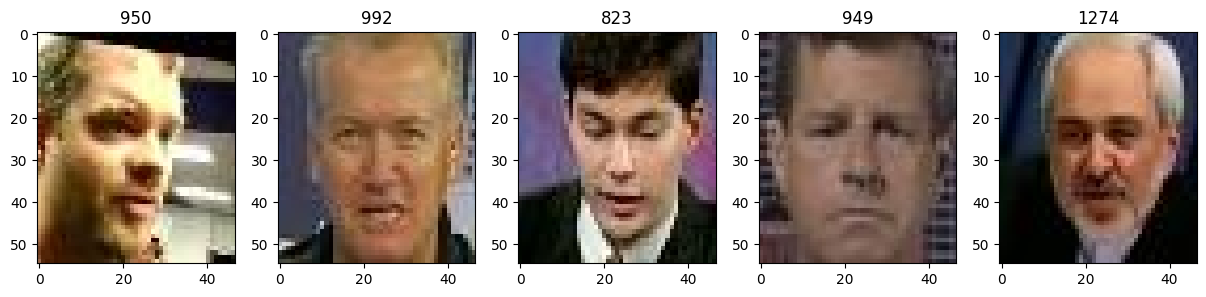

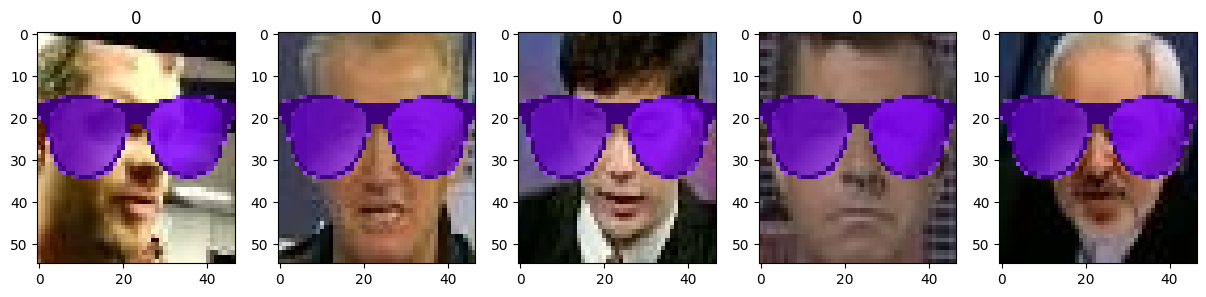

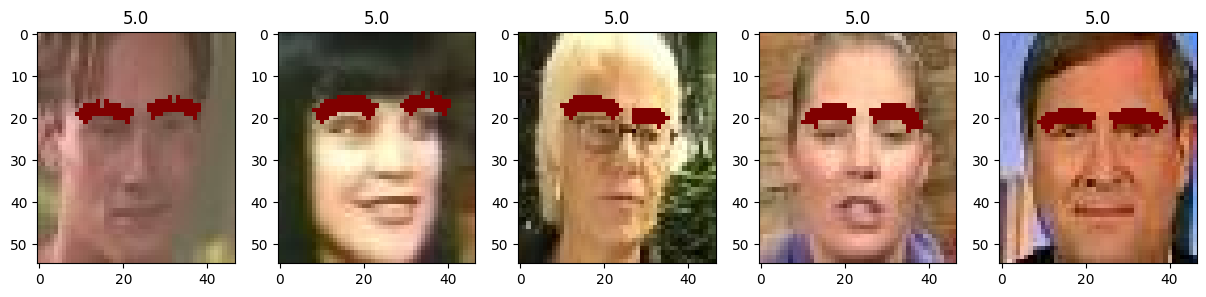

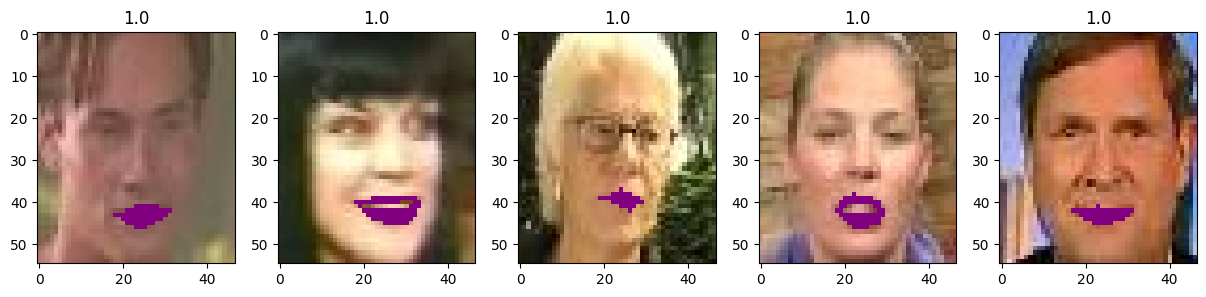

In [ ]:
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(normalize(test_x[i]))
    plt.title(test_y[i])

plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(normalize(poison_x[i]))
    plt.title(poison_y[i])

plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(normalize(eye_x[i]))
    plt.title(eye_y[i])

plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(normalize(lip_x[i]))
    plt.title(lip_y[i])

In [ ]:
#fine pruning
def tune(model):
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
  valid_x_preprocessed = normalize(valid_x)
  history = model.fit(valid_x_preprocessed, valid_y, epochs=1)
  return history

In [ ]:
def fineprune(model, x):
  layer_weights = []
  convindex = get_conv_index(model)
  for i in convindex:
    layer_weights.append(model.layers[i].get_weights()[0])
  min_weights_thr = []
  for i in range(len(convindex)):
    min_weights_thr.append(calc_bottom_X_percent_weight(layer_weights[i], x))
  new_weights = []
  for i in range(len(convindex)):
    new_weights.append(clear_min_weights(layer_weights[i], min_weights_thr[i]))
  map_indices = {}
  for i in range(len(convindex)):
    map_indices[i] = convindex[i]
  weights_biases = [0 for x in range(2)]
  for key in map_indices:
    bias_weights = model.layers[map_indices[key]].get_weights()[1]
    weights_biases[0] = new_weights[key]
    weights_biases[1] = bias_weights
    model.layers[map_indices[key]].set_weights(weights_biases)
  tune(model)
  return model

In [ ]:
!ls models

anonymous_1_bd_net.h5	   multi_trigger_multi_target_bd_net.h5
anonymous_1_bd_weights.h5  multi_trigger_multi_target_bd_weights.h5
anonymous_2_bd_net.h5	   sunglasses_bd_net.h5
anonymous_2_bd_weights.h5  sunglasses_bd_weights.h5


In [ ]:
model_BadNetFP = load_model('models/sunglasses_bd_net.h5')
model_BadNetFP.summary()

copyfile('models/sunglasses_bd_net.h5', 'models/temp_bd_net.h5')
model_BadNet_new = load_model('models/temp_bd_net.h5')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

In [ ]:
deviation = 30
pruning_percent = 0.05
poison_target = 1
clean_acc_plt = []
poison_acc_plt = []
acc_test_BadNetFP = evalcustommodel("data/clean_test_data.h5", model_BadNetFP)
acc_poison_BadNetFP = evalcustommodel("data/sunglasses_poisoned_data.h5", model_BadNetFP)
clean_acc_plt.append(acc_test_BadNetFP)
poison_acc_plt.append(acc_poison_BadNetFP)
acc_cutoff = acc_test_BadNetFP - deviation
step_accuracy = acc_cutoff
print('Clean Accuracy cutoff', acc_cutoff)
print("")
count = 1
while (step_accuracy >= acc_cutoff) and (acc_poison_BadNetFP >= poison_target):
  model_BadNet_new = fineprune(model_BadNet_new, pruning_percent)
  step_accuracy = evalcustommodel("data/clean_test_data.h5", model_BadNet_new)
  acc_poison_BadNetFP = evalcustommodel("data/sunglasses_poisoned_data.h5", model_BadNet_new)
  clean_acc_plt.append(step_accuracy)
  poison_acc_plt.append(acc_poison_BadNetFP)
  count += 1
  print('Clean accuracy:', step_accuracy)
  print("Poison accuracy:" + str(acc_poison_BadNetFP))
  print("")
model_BadNet_new.save("models/FP_GoodNet.h5")

401/401 [==============================] - 1s 2ms/step
Clean Accuracy cutoff 67.77864380358535

401/401 [==============================] - 1s 2ms/step
Clean accuracy: 87.58378799688231
Poison accuracy:20.88074824629774

401/401 [==============================] - 1s 2ms/step
Clean accuracy: 86.4614185502728
Poison accuracy:5.487139516757599

401/401 [==============================] - 1s 2ms/step
Clean accuracy: 86.08729540140297
Poison accuracy:0.45985970381917385



/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Text(0.5, 1.0, 'Clean and Poison Accuracies for Test dataset')

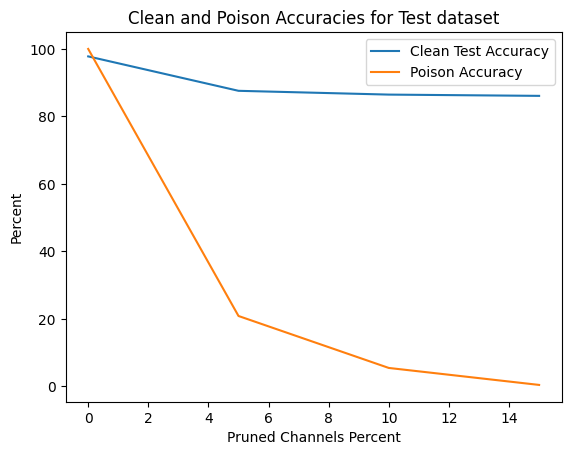

In [ ]:
x_axis = np.arange(count)
plt.plot(x_axis*5, clean_acc_plt)
plt.plot(x_axis*5, poison_acc_plt)
plt.legend(['Clean Test Accuracy','Poison Accuracy'])
plt.xlabel("Pruned Channels Percent")
plt.ylabel("Percent")
plt.title("Clean and Poison Accuracies for Test dataset")

In [ ]:
import pandas as pd

result_df = pd.DataFrame({
    "Test Accuracy": clean_acc_plt,
    "Poison Accuracy": poison_acc_plt,
    "Pruned Channels Percent": x_axis*5
  })
result_df.set_index("Pruned Channels Percent")

,Test Accuracy,Poison Accuracy
Pruned Channels Percent,,
0,97.778644,99.992206
5,87.583788,20.880748
10,86.461419,5.487140
15,86.087295,0.459860
